In [1]:
# Import the relevant modules

# Import the mathematical libraries
import math
import numpy as np
import pandas as pd

# Import the input output libraries
import os
import sys
import h5py

# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the machine learning libraries
from sklearn.model_selection import train_test_split
import pytorch_lightning as pL
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.transforms import v2
import torchsummary
torch.set_float32_matmul_precision('medium')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with h5py.File('Galaxy10_DECals.h5', 'r') as f:
    Galaxy10 = np.array(f['images'][:])
    labels = np.array(f['ans'][:])
Galaxy10.shape, labels.shape

((17736, 256, 256, 3), (17736,))

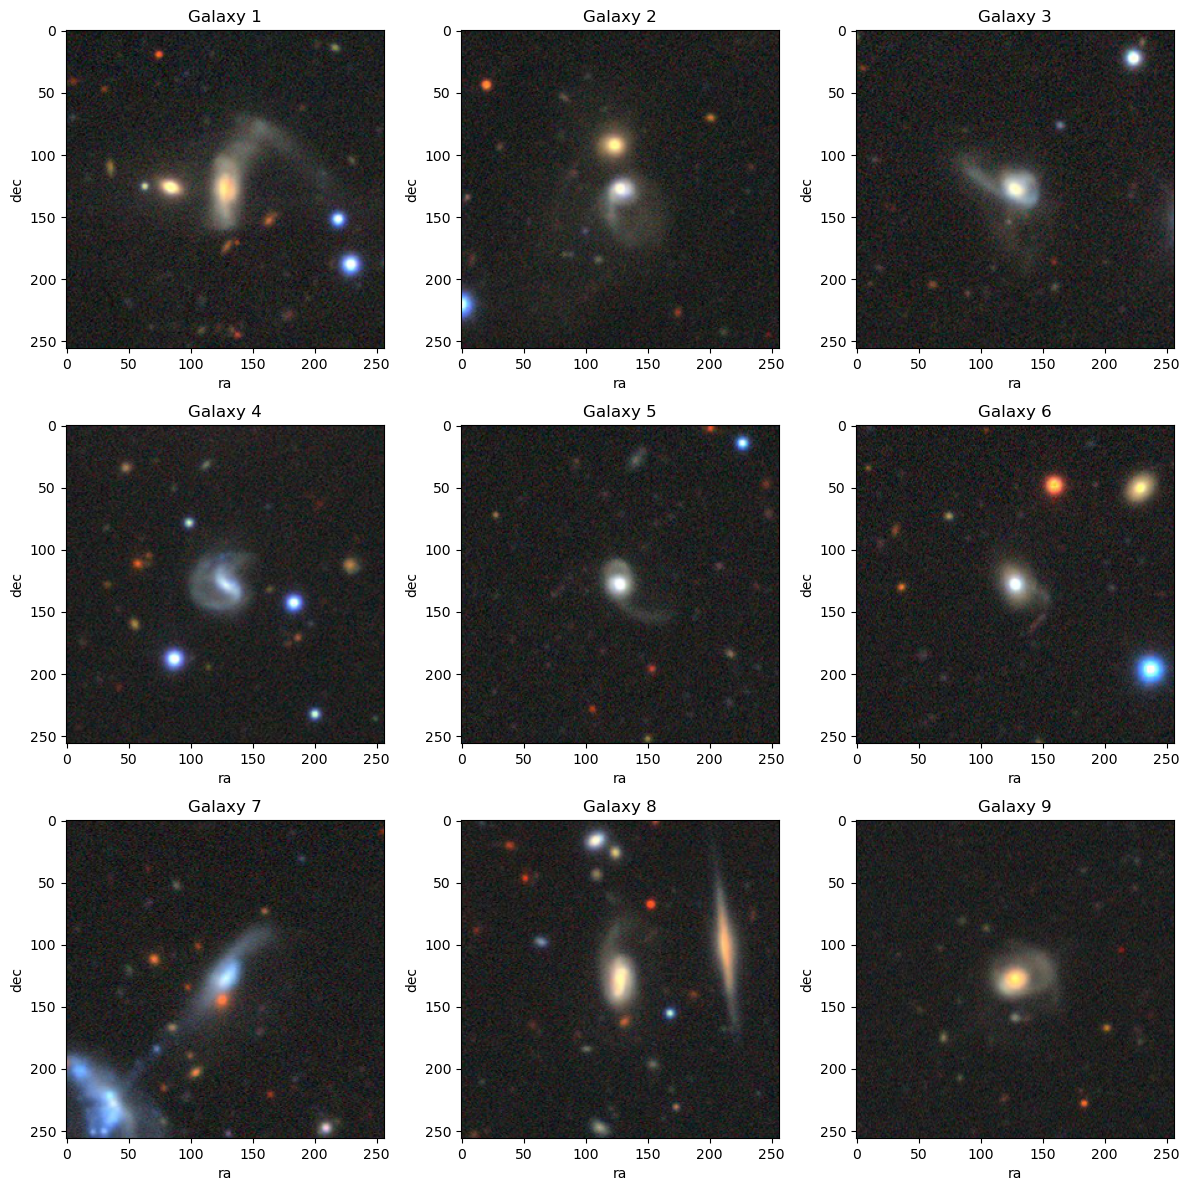

In [4]:
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Galaxy10[i])
    plt.title(f'Galaxy {i + 1}')
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.tight_layout()
plt.show()

In [5]:
Train_Validation_Images_Dataset, Test_Images_Dataset = Galaxy10[:int(len(Galaxy10) * 0.8)], Galaxy10[int(len(Galaxy10) * 0.8):]
Train_Validation_Labels_Dataset, Test_Labels_Dataset = labels[:int(len(labels) * 0.8)], labels[int(len(labels) * 0.8):]
Train_Validation_Images_Dataset.shape, Test_Images_Dataset.shape

((14188, 256, 256, 3), (3548, 256, 256, 3))

In [6]:
Train_Validation_Images_Dataset[0]

array([[[68, 19, 23],
        [58, 17, 33],
        [40, 16, 40],
        ...,
        [51, 46, 43],
        [40, 41, 33],
        [28, 38, 30]],

       [[61, 40, 37],
        [52, 43, 44],
        [29, 39, 41],
        ...,
        [28, 30, 42],
        [28, 32, 35],
        [33, 40, 33]],

       [[30, 31, 25],
        [24, 41, 33],
        [15, 45, 33],
        ...,
        [21, 35, 48],
        [25, 35, 45],
        [37, 41, 40]],

       ...,

       [[28, 32, 35],
        [27, 31, 32],
        [42, 44, 43],
        ...,
        [20, 37, 27],
        [19, 40, 21],
        [27, 50, 24]],

       [[22, 36, 37],
        [19, 29, 30],
        [33, 37, 38],
        ...,
        [17, 35, 35],
        [17, 35, 21],
        [26, 45, 17]],

       [[18, 39, 40],
        [14, 28, 29],
        [24, 30, 30],
        ...,
        [20, 35, 56],
        [27, 37, 36],
        [28, 36, 15]]], dtype=uint8)

In [7]:
from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline
          

ORIG_SHAPE = (256,256)
CROP_SIZE = (128,128)
IMG_SHAPE = (64,64)

def get_image(image, x1,y1, shape, crop_size):
    x = image
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x
    
def get_all_images(image_dataset, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = image_dataset
    y_batch = sel[:,1:]
    x_batch = []
    for index in tqdm(range(image_dataset.shape[0])):
        x = get_image(image_dataset[index], x1, y1, shape, crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(Train_Validation_Images_Dataset)
X_Valid, y_Valid = get_all_images(Test_Images_Dataset)
X_train.shape, y_train.shape, X_Valid.shape, y_Valid.shape

  0%|          | 0/14188 [00:00<?, ?it/s]

100%|██████████| 3548/3548 [00:03<00:00, 986.01it/s] 


((14188, 64, 64, 3),
 (14188, 255, 256, 3),
 (3548, 64, 64, 3),
 (3548, 255, 256, 3))

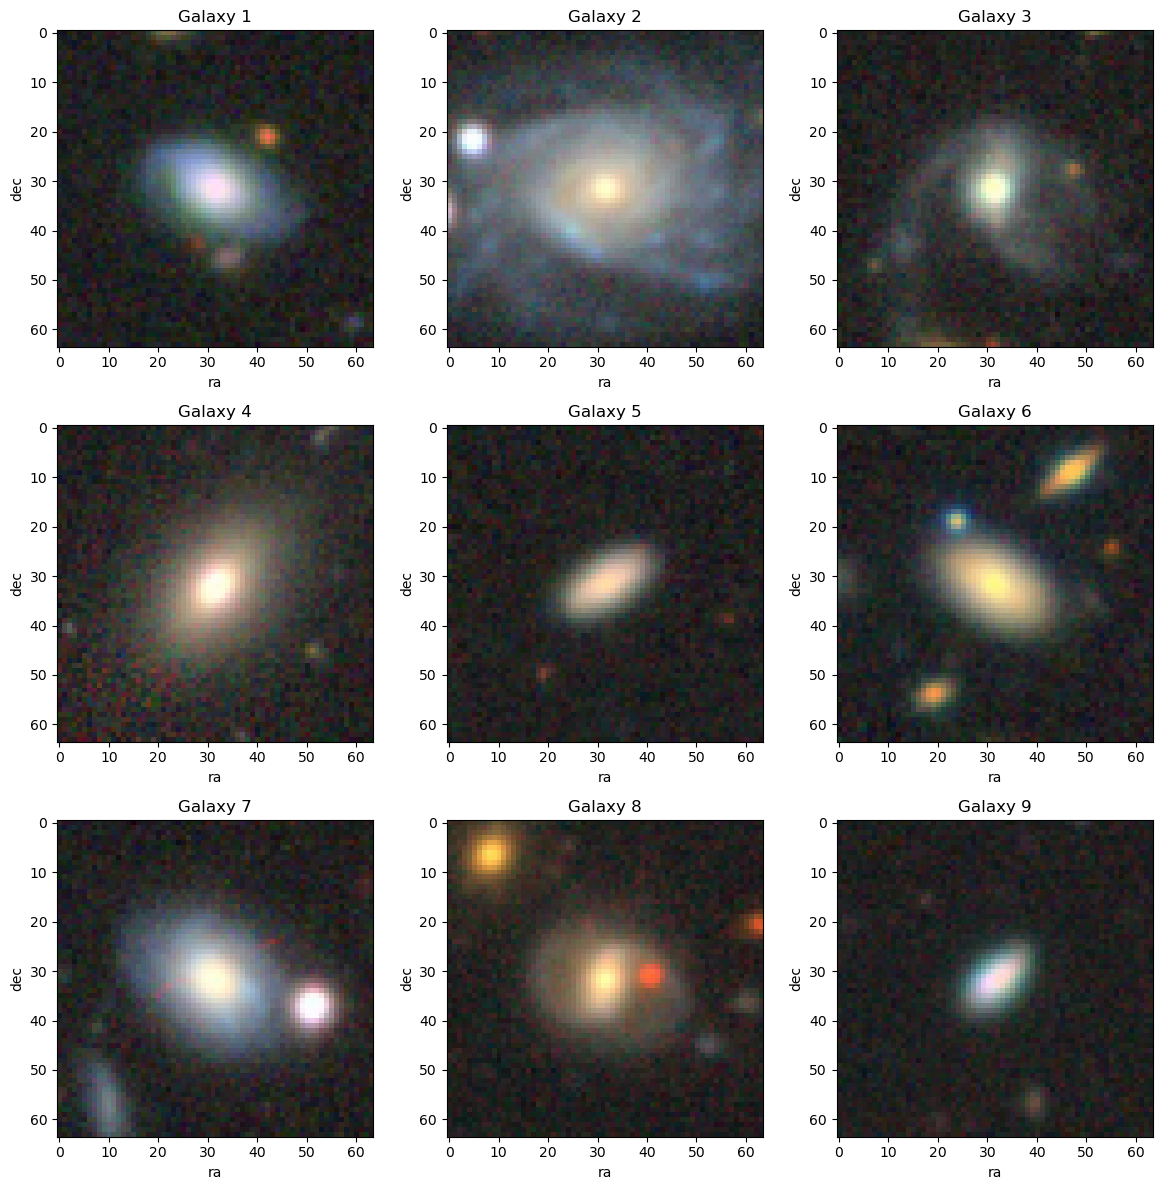

In [8]:
indices = np.random.choice(X_train.shape[0], 9)
Sample = X_train[indices]
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Sample[i])
    plt.title(f'Galaxy {i + 1}')
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.tight_layout()
plt.show()

In [9]:
# Generating a Synthetic Poisson Dataset:
Max_Photons = 1000
X_train_Poisson = np.random.poisson(X_train*Max_Photons)
X_Valid_Poisson = np.random.poisson(X_Valid*Max_Photons)
X_train_Poisson.shape, X_Valid_Poisson.shape

((14188, 64, 64, 3), (3548, 64, 64, 3))

In [10]:
X_train_Poisson.shape

(14188, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


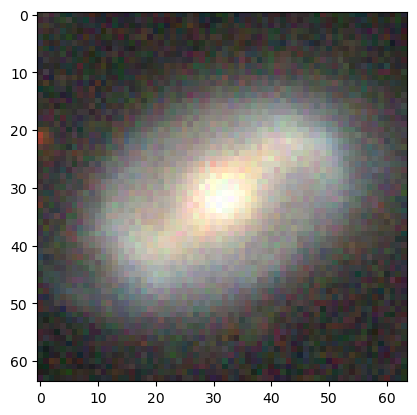

In [11]:
plt.imshow(X_train_Poisson[100]/1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


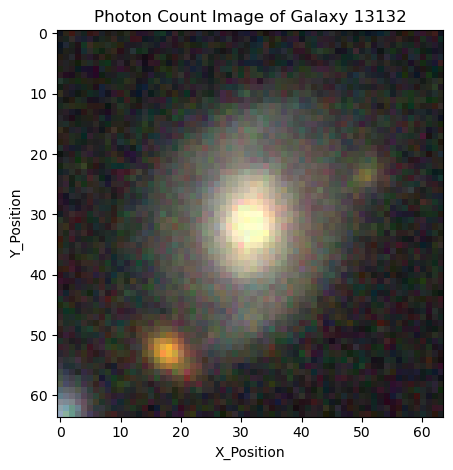

In [12]:
index = np.random.choice(X_train_Poisson.shape[0], 1)[0]
plt.imshow(X_train_Poisson[index]/1000.)
plt.xlabel("X_Position")
plt.ylabel("Y_Position")
plt.title(f"Photon Count Image of Galaxy {index}")
plt.tight_layout()
plt.show()

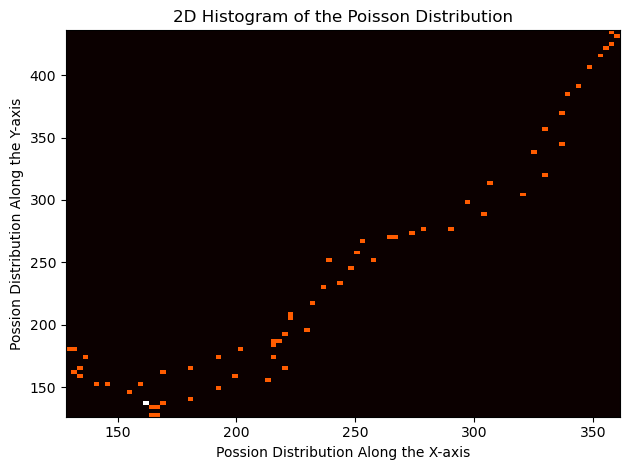

In [13]:
plt.hist2d(X_train_Poisson[index, :].mean(axis = 1).mean(axis = 1), X_train_Poisson[index, :].mean(axis = 0).mean(axis = 1), bins = 100, cmap = "hot")
plt.xlabel("Possion Distribution Along the X-axis")
plt.ylabel("Possion Distribution Along the Y-axis")
plt.title("2D Histogram of the Poisson Distribution")
plt.tight_layout()
plt.show()

In [14]:
F.mse_loss(torch.maximum(torch.FloatTensor([8]),torch.FloatTensor([25])), torch.maximum(torch.FloatTensor([3]),torch.FloatTensor([2])))

tensor(484.)

In [57]:
from torchmetrics import StructuralSimilarityIndexMeasure
def MSLE_Loss(y_pred, y_true):
    eps = torch.FloatTensor([1e-6]).to(device)
    mse = F.mse_loss(torch.log1p(torch.maximum(y_pred, eps)), torch.log1p(torch.maximum(y_true, eps)), reduction = 'mean')
    ssim = StructuralSimilarityIndexMeasure(data_range = 1.0, reduction = 'mean')(y_pred, y_true)
    return mse + ssim

In [205]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoise, self).__init__()
        self.stddev = stddev
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

In [307]:
class Encoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Encoder, self).__init__()

        self.GaussianNoise = GaussianNoise(0.1)
        self.BatchNorm0 = nn.BatchNorm2d(3)
        self.conv1a = nn.Conv2d(3, 8, 3, padding = 1) # 64 x 64
        self.conv1b = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv1c = nn.Conv2d(3, 16, 1)

        self.MaxPool1 = nn.MaxPool2d(2, 2)
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.LeakyReLU()

        self.conv2a = nn.Conv2d(16, 32, 3, padding = 1) # 32 x 32
        self.conv2b = nn.Conv2d(32, 64, 3, padding = 1) # 16 x 16
        self.conv2c = nn.Conv2d(16, 64, 1)

        self.MaxPool2 = nn.MaxPool2d(2, 2)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(dropout_rate)
        self.activation_2 = nn.LeakyReLU()

        self.conv3a = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16
        self.conv3b = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3c = nn.Conv2d(64, 128, 1)

        self.MaxPool3 = nn.MaxPool2d(2, 2)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout(dropout_rate)
        self.activation_3 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(dropout_rate)
        self.activation_4 = nn.LeakyReLU()


    def forward(self, x):
        x = self.GaussianNoise(x)
        x_skip = self.BatchNorm0(x)
        x = self.BatchNorm1(self.activation(self.conv1b(self.conv1a(x_skip))))
        x_skip = self.conv1c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout(x)
        x = self.MaxPool1(x)

        x_skip = x
        x = self.BatchNorm2(self.activation_2(self.conv2b(self.conv2a(x))))
        x_skip = self.conv2c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_2(x)
        x = self.MaxPool2(x)

        x_skip = x
        x = self.BatchNorm3(self.activation_3(self.conv3b(self.conv3a(x))))
        x_skip = self.conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_3(self.MaxPool3(x))

        x_skip = x
        x = self.BatchNorm4(self.activation_4(self.conv4b(self.conv4a(x))))
        x_skip = self.conv4c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_4(x)
        x = self.MaxPool4(x)

        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [354]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()

        self.layernorm1 = nn.LayerNorm([128, 8, 8])
        self.layernorm2 = nn.LayerNorm([64, 16, 16])
        self.layernorm3 = nn.LayerNorm([32, 32, 32])
        self.layernorm4 = nn.LayerNorm([16, 64, 64])
        self.layernorm5 = nn.LayerNorm([8, 128, 128])
        self.conv1 = nn.Conv2d(8, 3, 3, stride = 2, padding = 1)
        
    def UpsampleBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        return nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.GELU()
        ).to(device)
    def UpsampleTransposeBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GELU()
        ).to(device)
    
    def Pixel_Shuffle(self, in_channels, out_channels, upscale_factor, kernel_size = 3, stride = 1, padding = 1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels * (upscale_factor**2), kernel_size, stride, padding),
            nn.PixelShuffle(upscale_factor),
            nn.GELU()
        ).to(device)
    
    def forward(self, x):
        # x 4 x 4
        x = self.UpsampleBlock(256, 128)(x) # 8 x 8
        x = self.UpsampleTransposeBlock(128, 128, kernel_size = 3, stride = 1, padding = 1)(x) # 8 x 8
        x = self.layernorm1(x)

        x = self.UpsampleTransposeBlock(128, 64, kernel_size = 2, stride = 2, padding = 0)(x) # 16 x 16
        x = self.layernorm2(x)

        x = self.UpsampleBlock(64, 32)(x) # 32 x 32
        x = self.UpsampleTransposeBlock(32, 32, kernel_size = 3, stride = 1, padding = 1)(x) # 32 x 32
        x = self.layernorm3(x)

        x = self.UpsampleTransposeBlock(32, 16, kernel_size = 2, stride = 2, padding = 0)(x) # 64 x 64
        x = self.layernorm4(x)

        x = self.UpsampleBlock(16, 8)(x) # 8 x 8
        x = self.UpsampleTransposeBlock(8, 8, kernel_size = 3, stride = 1, padding = 1)(x) # 8 x 8
        x = self.layernorm5(x)
        
        x = self.conv1(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [313]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
        
        self.TransConv1 = nn.ConvTranspose2d(256, 128, 2, stride = 2, padding = 0) # 8 x 8
        #self.Conv1 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.GELU()

        self.TransConv2 = nn.ConvTranspose2d(128, 64, 2, stride = 2, padding = 0) # 16 x 16
        #self.Conv2 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.GELU()

        self.TransConv3 = nn.ConvTranspose2d(64, 32, 2, stride = 2, padding = 0) # 32 x 32
        #self.Conv3 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.GELU()

        self.TransConv4 = nn.ConvTranspose2d(32, 3, 2, stride = 2, padding = 0) # 64 x 64
        #self.Conv4 = nn.Conv2d(3, 3, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.ReLU()

    
    def forward(self, x):
        # x 4 x 4
        x = self.activation1(self.Batchnorm1(self.TransConv1(x)))
        x = self.dropout1(x)

        x = self.activation2(self.Batchnorm2(self.TransConv2(x)))
        x = self.dropout2(x)

        x = self.activation3(self.Batchnorm3(self.TransConv3(x)))
        x = self.dropout3(x)
        
        x = self.activation4(self.Batchnorm4(self.TransConv4(x)))
        x = self.dropout4(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [366]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
        
        self.TransConv1 = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding= 1, output_padding= 1) # 8 x 8
        #self.Conv1 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.ReLU()

        self.Upsample1 = nn.Upsample(scale_factor = 2, mode = 'nearest') # 16 x 16
        self.Conv2 = nn.Conv2d(128, 64, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.ReLU()

        self.TransConv3 = nn.ConvTranspose2d(64, 32, 3, stride = 2, padding = 1, output_padding = 1) # 32 x 32
        #self.Conv3 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.ReLU()

        self.Upsample2 = nn.Upsample(scale_factor=2, mode = "nearest") # 64 x 64
        self.Conv4 = nn.Conv2d(32, 3, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.ReLU()

    
    def forward(self, x):
        # x 4 x 4
        x = self.TransConv1(x) 
        x = self.activation1(self.Batchnorm1(x))
        x = self.dropout1(x)

        x = self.Upsample1(x)
        x = self.activation2(self.Batchnorm2(self.Conv2(x)))
        x = self.dropout2(x)

        x = self.TransConv3(x)
        x = self.activation3(self.Batchnorm3(x))
        x = self.dropout3(x)

        x = self.Upsample2(x)
        x = self.activation4(self.Batchnorm4(self.Conv4(x)))
        x = self.dropout4(x)
        
        x = F.relu(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [62]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
    
        self.Upsample1 = nn.Upsample(scale_factor = 2, mode = 'bilinear') # 8 x 8
        self.Conv1a = nn.Conv2d(256, 128, 3, stride = 1, padding = 1)
        self.Conv1b = nn.Conv2d(128, 64, 1, stride = 1, padding = 0)
        self.Batchnorm1 = nn.BatchNorm2d(64)
        #self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.LeakyReLU()

        self.Upsample2 = nn.Upsample(scale_factor = 2, mode = 'bilinear') # 16 x 16
        self.Conv2a = nn.Conv2d(64, 32, 3, stride = 1, padding = 1)
        self.Conv2b = nn.Conv2d(32, 16, 1, stride = 1, padding = 0)
        self.Batchnorm2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.LeakyReLU()

        self.Upsample3 = nn.Upsample(scale_factor = 2, mode = 'bilinear') # 32 x 32
        self.Conv3a = nn.Conv2d(16, 8, 3, stride = 1, padding = 1)
        self.Conv3b = nn.Conv2d(8, 4, 1, stride = 1, padding = 0)
        self.Batchnorm3 = nn.BatchNorm2d(4)
        #self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.LeakyReLU()

        self.Upsample4 = nn.Upsample(scale_factor = 2, mode = 'bilinear') # 64 x 64
        self.Conv4a = nn.Conv2d(4, 3, 3, stride = 1, padding = 1)
        self.Conv4b = nn.Conv2d(3, 3, 1, stride = 1, padding = 0)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        #self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.LeakyReLU()

    
    def forward(self, x):
        # x 4 x 4
        x = self.Upsample1(x)
        x = self.activation1(self.Batchnorm1(self.Conv1b(self.Conv1a(x))))
        #x = self.dropout1(x)

        x = self.Upsample2(x)
        x = self.activation2(self.Batchnorm2(self.Conv2b(self.Conv2a(x))))
        #x = self.dropout2(x)

        x = self.Upsample3(x)
        x = self.activation3(self.Batchnorm3(self.Conv3b(self.Conv3a(x))))
        #x = self.dropout3(x)
         
        x = self.Upsample4(x)
        x = self.activation4(self.Batchnorm4(self.Conv4b(self.Conv4a(x))))
        #x = self.dropout4(x)
        
        x = F.relu(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [182]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
    
        self.TransConv1a = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding= 1, output_padding= 1) # 8 x 8
        self.Conv1b = nn.Conv2d(128, 64, 3, stride = 1, padding = 1) 
        self.Conv1c = nn.Conv2d(128, 64, 1, stride = 1, padding = 0)
        self.Conv1d = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(64)
        #self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.LeakyReLU()

        self.TransConv2a = nn.ConvTranspose2d(64, 32, 2, stride = 2, padding= 0, output_padding= 0) # 16 x 16
        self.Conv2b = nn.Conv2d(32, 16, 3, stride = 1, padding = 1) 
        self.Conv2c = nn.Conv2d(32, 16, 1, stride = 1, padding = 0)
        self.Conv2d = nn.Conv2d(16, 16, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.LeakyReLU()

        self.TransConv3a = nn.ConvTranspose2d(16, 8, 3, stride = 2, padding= 1, output_padding= 1) # 32 x 32
        self.Conv3b = nn.Conv2d(8, 4, 3, stride = 1, padding = 1)
        self.Conv3c = nn.Conv2d(8, 4, 1, stride = 1, padding = 0) 
        self.Conv3d = nn.Conv2d(4, 4, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(4)
        #self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.LeakyReLU()

        self.TransConv4a = nn.ConvTranspose2d(4, 3, 2, stride = 2, padding= 0, output_padding= 0) # 64 x 64
        self.Conv4b = nn.Conv2d(3, 3, 3, stride = 1, padding = 1) 
        self.Conv4c = nn.Conv2d(3, 3, 1, stride = 1, padding = 0)
        self.Conv4d = nn.Conv2d(3, 3, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        #self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.LeakyReLU()

    
    def forward(self, x):
        # x 4 x 4
        x_skip = self.TransConv1a(x)
        x = self.activation1(self.Batchnorm1(self.Conv1b(x_skip)))
        x_skip = self.Conv1c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv1d(x)
        #x = self.dropout1(x)

        x_skip = self.TransConv2a(x)
        x = self.activation2(self.Batchnorm2(self.Conv2b(x_skip)))
        x_skip = self.Conv2c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv2d(x)
        # x = self.dropout2(x)

        x_skip = self.TransConv3a(x)
        x = self.activation2(self.Batchnorm3(self.Conv3b(x_skip)))
        x_skip = self.Conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv3d(x)
        # x = self.dropout3(x)

        x_skip = self.TransConv4a(x)
        x = self.activation2(self.Batchnorm4(self.Conv4b(x_skip)))
        x_skip = self.Conv4c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv4d(x)
        #x = self.dropout4(x)
        
        x = F.sigmoid(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [318]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
    
        self.TransConv1a = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding= 1, output_padding= 1) # 4 x 4
        self.Conv1b = nn.Conv2d(128, 64, 3, stride = 1, padding = 1) 
        self.Conv1c = nn.Conv2d(128, 64, 1, stride = 1, padding = 0)
        self.Conv1d = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(64)
        #self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.LeakyReLU()

        self.TransConv2a = nn.ConvTranspose2d(64, 32, 2, stride = 2, padding= 0, output_padding= 0) # 8 x 8
        self.Conv2b = nn.Conv2d(32, 16, 3, stride = 1, padding = 1) 
        self.Conv2c = nn.Conv2d(32, 16, 1, stride = 1, padding = 0)
        self.Conv2d = nn.Conv2d(16, 16, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.LeakyReLU()

        self.TransConv3a = nn.ConvTranspose2d(16, 8, 3, stride = 2, padding= 1, output_padding= 1) # 16 x 16
        self.Conv3b = nn.Conv2d(8, 4, 3, stride = 1, padding = 1)
        self.Conv3c = nn.Conv2d(8, 4, 1, stride = 1, padding = 0) 
        self.Conv3d = nn.Conv2d(4, 4, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(4)
        #self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.LeakyReLU()

        self.TransConv4a = nn.ConvTranspose2d(4, 3, 2, stride = 2, padding= 0, output_padding= 0) # 32 x 32
        self.Conv4b = nn.Conv2d(3, 3, 3, stride = 1, padding = 1) 
        self.Conv4c = nn.Conv2d(3, 3, 1, stride = 1, padding = 0)
        self.Conv4d = nn.Conv2d(3, 3, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(3)
        #self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.LeakyReLU()

    
    def forward(self, x):
        # x 4 x 4
        x_skip = self.TransConv1a(x)
        x = self.activation1(self.Batchnorm1(self.Conv1b(x_skip)))
        x_skip = self.Conv1c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv1d(x)
        #x = self.dropout1(x)

        x_skip = self.TransConv2a(x)
        x = self.activation2(self.Batchnorm2(self.Conv2b(x_skip)))
        x_skip = self.Conv2c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv2d(x)
        # x = self.dropout2(x)

        x_skip = self.TransConv3a(x)
        x = self.activation3(self.Batchnorm3(self.Conv3b(x_skip)))
        x_skip = self.Conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv3d(x)
        # x = self.dropout3(x)

        x_skip = self.TransConv4a(x)
        x = self.activation4(self.Batchnorm4(self.Conv4b(x_skip)))
        x_skip = self.Conv4c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv4d(x)
        #x = self.dropout4(x)
        
        x = F.sigmoid(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [211]:
class Stochastic_Rounding(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        lower = torch.floor(input)
        upper = torch.ceil(input)
        probability = input - lower
        ctx.save_for_backward(lower, upper, probability)
        output = torch.where(torch.rand_like(input) < probability, upper, lower)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

Stochastic_Rounding = Stochastic_Rounding.apply

In [138]:
class Convolutional_AE(pL.LightningModule):
    def __init__(self, learning_rate, dropout_rate, weight_decay):
        super(Convolutional_AE, self).__init__()
        
        self.encoder = Encoder(dropout_rate)
        self.decoder = Decoder(dropout_rate)
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def latent_space(self, x):
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Training_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Validation_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience = 10, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        ReconstructedImage = self.forward(x)
        return ReconstructedImage
    
    def latent_space_step(self, batch, batch_idx):
        x, y = batch
        LatentSpace = self.latent_space(x)
        return LatentSpace
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Test_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

In [312]:
class Possion_AE(pL.LightningModule):
    def __init__(self, lambda_1, lambda_2, lambda_prior_mean, learning_rate, weight_decay):
        super(Possion_AE, self).__init__()
        
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2 
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.lambda_prior_mean = lambda_prior_mean

    def Encoding_Process(self, x):
        return torch.exp(self.encoder(x))

    def Decoding_Process(self, x):
        return self.decoder(x)

    def forward(self, x):
        Lambda_Image = self.Encoding_Process(x)
        Poisson_Image = Stochastic_Rounding(Lambda_Image)
        Reconstructed_Image = self.Decoding_Process(Poisson_Image)
        Reconstructed_Poisson_Image = Stochastic_Rounding(Reconstructed_Image)
        return Reconstructed_Poisson_Image, Poisson_Image
    
    def Loss_Function(self, Reconstructed_Poisson_Image, Target_Image, Poisson_Image):

        # Reconstruction Loss Function MSE
        MSE_Loss = F.mse_loss(Reconstructed_Poisson_Image, Target_Image)

        # Poisson Loss Function
        Reconstructed_Poisson_Image_Mean = torch.mean(Reconstructed_Poisson_Image, dim = 0)
        Poisson_Loss = torch.mean(Reconstructed_Poisson_Image_Mean - Target_Image * torch.log(Reconstructed_Poisson_Image_Mean + 1e-7))

        # Regularization Loss Function (Kullback-Leibler Divergence)
        Poisson_Image_Mean = torch.mean(Poisson_Image, dim = 0)
        Regularization_Loss = torch.mean(Poisson_Image_Mean * torch.log(Poisson_Image_Mean / (self.lambda_prior_mean + 1e-7)) + Poisson_Image_Mean - self.lambda_prior_mean)

        return MSE_Loss + self.lambda_2*Regularization_Loss #+ self.lambda_1 * Poisson_Loss + self.lambda_2 * Regularization_Loss
        #return Poisson_Loss + self.lambda_2 * Regularization_Loss
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        Reconstructed_Poisson_Image, Poisson_Image = self.forward(x)
        loss = self.Loss_Function(Reconstructed_Poisson_Image, y, Poisson_Image)
        self.log("Training_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        Reconstructed_Poisson_Image, Poisson_Image = self.forward(x)
        loss = self.Loss_Function(Reconstructed_Poisson_Image, y, Poisson_Image)
        self.log("Validation_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        Reconstructed_Poisson_Image, Poisson_Image = self.forward(x)
        Loss = self.Loss_Function(Reconstructed_Poisson_Image, y, Poisson_Image)
        self.log("Test_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        Reconstructed_Poisson_Image, Poisson_Image = self.forward(x)
        return Reconstructed_Poisson_Image, Poisson_Image
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience = 10, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]


In [140]:
type(X_train_Poisson)

numpy.ndarray

In [141]:
X_Train_Poisson_Tensor = torch.tensor(X_train_Poisson).float().permute(0, 3, 1, 2).to(device)
X_Train_Tensor = torch.tensor(X_train).float().permute(0, 3, 1, 2).to(device)
Y_Train_Tensor = torch.tensor(X_train).float().permute(0, 3, 1, 2).to(device)
X_Train_Poisson_Tensor.shape, Y_Train_Tensor.shape

(torch.Size([14188, 3, 64, 64]), torch.Size([14188, 3, 64, 64]))

In [35]:
X_Valid_Poisson_Tensor = torch.tensor(X_Valid_Poisson).float().permute(0, 3, 1, 2).to(device)
X_Valid_Tensor = torch.tensor(X_Valid).float().permute(0, 3, 1, 2).to(device)
Y_Valid_Tensor = torch.tensor(X_Valid).float().permute(0, 3, 1, 2).to(device)
X_Valid_Poisson_Tensor.shape, Y_Valid_Tensor.shape

(torch.Size([3548, 3, 64, 64]), torch.Size([3548, 3, 64, 64]))

In [36]:
X_Train_Poisson_Dataloder = DataLoader(list(zip(X_Train_Poisson_Tensor, X_Train_Poisson_Tensor)), batch_size = 32, shuffle = True)
X_Valid_Poisson_Dataloder = DataLoader(list(zip(X_Valid_Poisson_Tensor, X_Valid_Poisson_Tensor)), batch_size = 32, shuffle = False)
X_Train_Poisson_Dataloder

In [174]:
X_Train_Dataloder = DataLoader(list(zip(X_Train_Tensor, X_Train_Tensor)), batch_size = 64, shuffle = True)
X_Valid_Dataloder = DataLoader(list(zip(X_Valid_Tensor, X_Valid_Tensor)), batch_size = 64, shuffle = False)
X_Train_Dataloder

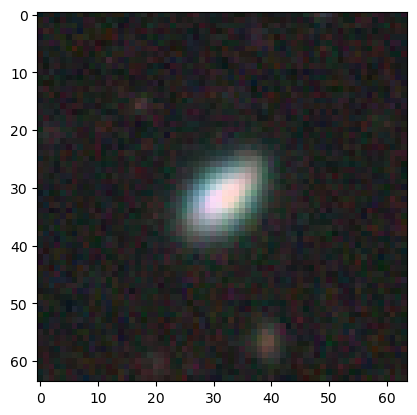

In [175]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem)
    break

(array([5371., 6150.,  304.,  122.,   83.,   71.,   54.,   50.,   56.,
          27.]),
 array([0.02562367, 0.12305965, 0.22049564, 0.31793162, 0.4153676 ,
        0.51280355, 0.61023957, 0.70767552, 0.80511153, 0.90254748,
        0.99998349]),
 <BarContainer object of 10 artists>)

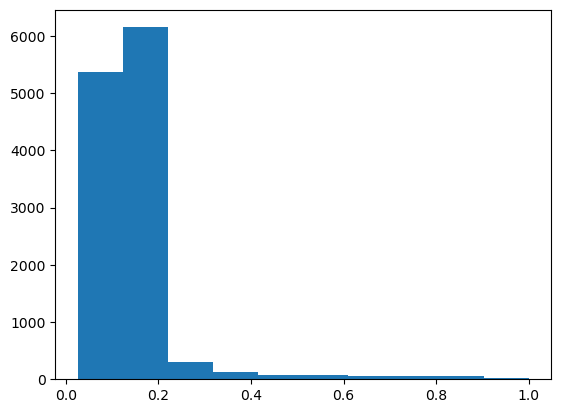

In [176]:
plt.hist(element.detach().cpu().numpy().reshape(-1,))

In [177]:
device.type

'cuda'

In [319]:
AE_Model = Convolutional_AE(learning_rate = 2e-3, dropout_rate= 0.15, weight_decay = 1e-5)
AE_Model = AE_Model.to(device)

In [320]:
torchsummary.summary(AE_Model, (3, 64, 64), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1            [-1, 3, 64, 64]               0
       BatchNorm2d-2            [-1, 3, 64, 64]               6
            Conv2d-3            [-1, 8, 64, 64]             224
            Conv2d-4           [-1, 16, 64, 64]           1,168
         LeakyReLU-5           [-1, 16, 64, 64]               0
       BatchNorm2d-6           [-1, 16, 64, 64]              32
            Conv2d-7           [-1, 16, 64, 64]              64
         MaxPool2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,640
           Conv2d-10           [-1, 64, 32, 32]          18,496
        LeakyReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]           1,088
        MaxPool2d-14           [-1, 64,

In [321]:
element = element.view(-1, 3, 64, 64)
element = element.to(device)
element.shape

torch.Size([1, 3, 64, 64])

In [322]:
AE_Model.predict_step((element, element), 1).shape

torch.Size([1, 3, 64, 64])

In [323]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 10, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss", save_top_k = 1, mode = "min", save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "Possion_AE")
Max_Epochs = 100

name = "CAE"
CHECKPOINT_PATH = './models/'

Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

Trainer.fit(AE_Model, X_Train_Dataloder, X_Valid_Dataloder)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.2 M 
1 | decoder | Decoder | 431 K 
------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [324]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0025777549017220736   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0025777549017220736}]

In [372]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0029532185290008783   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0029532185290008783}]

In [424]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.002445674268528819    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.002445674268528819}]

In [281]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │    0.00203430256806314    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.00203430256806314}]

In [45]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0035923246759921312   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0035923246759921312}]

In [304]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0011929107131436467   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0011929107131436467}]

In [373]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0029532185290008783   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0029532185290008783}]

In [ ]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.007921862415969372    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.007921862415969372}]

In [ ]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.007930343970656395    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.007930343970656395}]

In [282]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0020343030337244272   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0020343030337244272}]

In [399]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0021992994006723166   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0021992994006723166}]

In [46]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.004762811120599508    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.004762811120599508}]

In [425]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0034333071671426296   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0034333071671426296}]

In [374]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.004104027058929205    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.004104027058929205}]

In [400]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.002680815290659666    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.002680815290659666}]

In [337]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0021344181150197983   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0021344181150197983}]

In [305]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0015027892077341676   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0015027892077341676}]

In [ ]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │    0.04576165974140167    │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.04576165974140167}]

In [325]:
element = element.to(device)
AE_Model.to(device)

Convolutional_AE(
  (encoder): Encoder(
    (GaussianNoise): GaussianNoise()
    (BatchNorm0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1a): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1b): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1c): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (BatchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.15, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01)
    (conv2a): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2b): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2c): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Ba

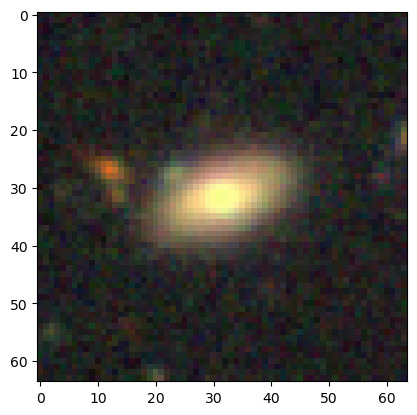

In [351]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem)
    break

In [352]:
element = element.view(-1, 3, 64, 64).to(device)
Trial = AE_Model.predict_step((element, element), 1)
Trial.shape

torch.Size([1, 3, 64, 64])

In [353]:
element

tensor([[[[0.1482, 0.1060, 0.0901,  ..., 0.0876, 0.1258, 0.1765],
          [0.0981, 0.1110, 0.1767,  ..., 0.1029, 0.1975, 0.1505],
          [0.1908, 0.1233, 0.0874,  ..., 0.1715, 0.1565, 0.1875],
          ...,
          [0.1988, 0.0775, 0.1301,  ..., 0.0892, 0.1712, 0.0926],
          [0.1966, 0.1456, 0.0812,  ..., 0.1480, 0.0767, 0.0930],
          [0.1011, 0.1249, 0.0934,  ..., 0.1783, 0.0856, 0.1061]],

         [[0.0923, 0.0965, 0.1603,  ..., 0.1632, 0.1993, 0.0934],
          [0.1059, 0.0650, 0.1041,  ..., 0.1176, 0.1108, 0.1695],
          [0.0717, 0.0338, 0.1059,  ..., 0.1449, 0.1070, 0.1607],
          ...,
          [0.1135, 0.0913, 0.0963,  ..., 0.1160, 0.1177, 0.0849],
          [0.1451, 0.0988, 0.0920,  ..., 0.1344, 0.1458, 0.1136],
          [0.1420, 0.1068, 0.1038,  ..., 0.1412, 0.1329, 0.0712]],

         [[0.1023, 0.1472, 0.1622,  ..., 0.1080, 0.0845, 0.0874],
          [0.1824, 0.1377, 0.1783,  ..., 0.1227, 0.1925, 0.1915],
          [0.0813, 0.1145, 0.1458,  ..., 0

In [354]:
Trial

tensor([[[[0.1763, 0.1450, 0.1321,  ..., 0.1436, 0.1458, 0.1532],
          [0.1329, 0.1317, 0.1404,  ..., 0.1546, 0.1616, 0.1582],
          [0.1307, 0.1387, 0.1438,  ..., 0.1575, 0.1607, 0.1513],
          ...,
          [0.1587, 0.1629, 0.1650,  ..., 0.1407, 0.1353, 0.1301],
          [0.1523, 0.1603, 0.1611,  ..., 0.1369, 0.1372, 0.1408],
          [0.1983, 0.1442, 0.1479,  ..., 0.1255, 0.1261, 0.1401]],

         [[0.1527, 0.1309, 0.1301,  ..., 0.1426, 0.1361, 0.1925],
          [0.1335, 0.1360, 0.1403,  ..., 0.1554, 0.1592, 0.1443],
          [0.1284, 0.1338, 0.1400,  ..., 0.1530, 0.1560, 0.1453],
          ...,
          [0.1554, 0.1624, 0.1639,  ..., 0.1349, 0.1311, 0.1237],
          [0.1656, 0.1565, 0.1519,  ..., 0.1247, 0.1181, 0.1160],
          [0.1534, 0.1566, 0.1376,  ..., 0.1165, 0.1119, 0.1655]],

         [[0.1518, 0.1252, 0.1267,  ..., 0.1380, 0.1510, 0.1535],
          [0.1277, 0.1341, 0.1306,  ..., 0.1465, 0.1465, 0.1459],
          [0.1303, 0.1375, 0.1377,  ..., 0

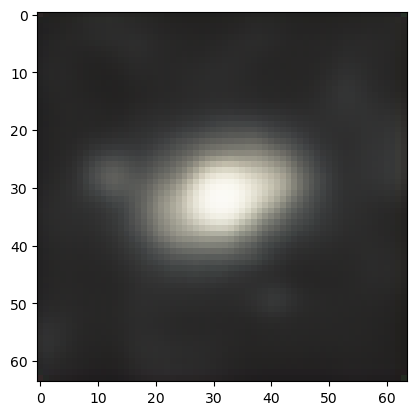

In [355]:
Trialler = Trial.permute(0,2,3,1).detach().cpu().numpy()
Trialler = Trialler[0]
plt.imshow(Trialler)